# TSUNAMI Package Vignette

This notebook demonstrates the key features of the TSUNAMI package, a comprehensive framework for survival analysis and multi-task learning.

In this vignette, we will:
1. Load and preprocess the EBMT dataset (European Bone Marrow Transplantation registry data)
2. Create synthetic target variables to demonstrate multi-task capability
3. Implement three demonstrations:
   - Single Risk Survival Analysis
   - Competing Risks Analysis
   - Multi-Task Learning
4. Visualize results with various plots:
   - Survival curves with uncertainty quantification
   - Feature importance using different methods
   - Feature effect visualization (partial dependence, ICE curves, interactions)
   - Task-specific outputs

Let's begin by importing the necessary libraries and setting up our environment.

In [30]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import warnings

# Add the project root to the Python path
project_root = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
sys.path.insert(0, project_root)

# Import TSUNAMI modules
from enhanced_deephit.data.processing import DataProcessor
from enhanced_deephit.models import EnhancedDeepHit
from enhanced_deephit.models.tasks.base import TaskHead
from enhanced_deephit.models.tasks.standard import ClassificationHead, RegressionHead
from enhanced_deephit.models.tasks.survival import SingleRiskHead, CompetingRisksHead
from enhanced_deephit.visualization.importance.importance import (
    PermutationImportance,
    ShapImportance,
    IntegratedGradients,
    AttentionImportance
)
from enhanced_deephit.visualization.survival_plots import (
    plot_survival_curve,
    plot_cumulative_incidence,
    plot_calibration_curve
)
from enhanced_deephit.visualization.feature_effects import (
    plot_partial_dependence,
    plot_ice_curves,
    plot_feature_interaction
)

# Ignore warnings for cleaner output
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Create output directory for plots
os.makedirs("plots", exist_ok=True)

## 1. Loading and Exploring the EBMT Dataset

We'll start by loading the European Bone Marrow Transplantation (EBMT) registry dataset, which contains information about patients who received bone marrow transplants and their outcomes. 

This dataset includes various patient characteristics, treatment details, and survival outcomes, making it ideal for demonstrating survival analysis methods.

In [31]:
# Load and explore the EBMT dataset
print("Loading EBMT dataset...")
ebmt_data = pd.read_csv('ebmt3.csv')
print(f"Dataset loaded: {ebmt_data.shape[0]} patients, {ebmt_data.shape[1]} variables")

# Display dataset information
print("\nDataset Information:")
ebmt_data.head()

Loading EBMT dataset...
Dataset loaded: 8966 patients, 10 variables

Dataset Information:


,Unnamed: 0,id,time,status,cod,dissub,match,tcd,year,age
0,1,1,24.453574,0,Alive,CML,Gender mismatch,No TCD,1995-1998,>40
1,2,2,14.626130,1,Relapse,CML,No gender mismatch,No TCD,1995-1998,>40
2,3,3,4.437141,6,Other,CML,No gender mismatch,No TCD,1995-1998,>40
3,4,4,32.703369,0,Alive,AML,No gender mismatch,No TCD,1995-1998,20-40
4,5,5,19.030403,1,Relapse,AML,No gender mismatch,No TCD,1995-1998,20-40


In [32]:
# Variable types and missing values
print("Variable types and counts:")
print(ebmt_data.dtypes)

print("\nMissing values:")
print(ebmt_data.isnull().sum())

Variable types and counts:
Unnamed: 0      int64
id              int64
time          float64
status          int64
cod            object
dissub         object
match          object
tcd            object
year           object
age            object
dtype: object

Missing values:
Unnamed: 0    0
id            0
time          0
status        0
cod           0
dissub        0
match         0
tcd           0
year          0
age           0
dtype: int64


In [33]:
# Basic statistics of the time-to-event variables
print("Time-to-event statistics:")
print("\ntime:")
print(ebmt_data['time'].describe())

# Event counts
print("\nEvent counts:")
print("\nstatus:")
print(ebmt_data['status'].value_counts())

Time-to-event statistics:

time:
count    8966.000000
mean       52.223723
std        48.957706
min         0.001000
25%         7.428102
50%        40.838127
75%        84.831553
max       211.372227
Name: time, dtype: float64

Event counts:

status:
status
0    5656
1    1098
6     924
2     834
5     156
3     151
4     147
Name: count, dtype: int64


In [34]:
# Categorical variable distributions
print("Categorical variable distributions:")
for cat_var in ['dissub', 'age', 'match', 'tcd']:
    print(f"\n{cat_var}:")
    print(ebmt_data[cat_var].value_counts())

Categorical variable distributions:

dissub:
dissub
CML    3582
AML    3514
ALL    1870
Name: count, dtype: int64

age:
age
20-40    4800
>40      2192
<=20     1974
Name: count, dtype: int64

match:
match
No gender mismatch    6758
Gender mismatch       2208
Name: count, dtype: int64

tcd:
tcd
No TCD     4390
Unknown    2856
TCD        1720
Name: count, dtype: int64


## 2. Creating Synthetic Variables for Multi-Task Demonstration

To demonstrate the multi-task learning capabilities of TSUNAMI, we'll create additional synthetic target variables:
1. A binary classification target (`binary_outcome`)
2. A regression target (`biomarker`)
3. A competing risks cause indicator (`cr_cause`)

We'll also rename some columns for clarity in modeling.

In [35]:
# Rename columns for clarity in modeling
ebmt_data = ebmt_data.rename(columns={
    'time': 'survival_time',
    'status': 'event_indicator',
    'match': 'drmatch'  # More descriptive name
})

# Simplify event indicator for demonstration (0: censored, 1: event)
# Original dataset has 0, 1, 2, 3, 4, 5, 6 statuses
ebmt_data['event_indicator'] = (ebmt_data['event_indicator'] > 0).astype(int)

# Synthetic binary classification target
ebmt_data['binary_outcome'] = np.random.binomial(1, 0.3, size=len(ebmt_data))

# Synthetic regression target (e.g., biomarker value)
ebmt_data['biomarker'] = 0.5 * ebmt_data['survival_time'] + 0.3 * (ebmt_data['age'] == ">40").astype(int) * 10 + np.random.normal(0, 5, size=len(ebmt_data))

# Synthetic competing risks (create a cause indicator from 'cod' column)
# 0: censored, 1: Relapse, 2: Death without relapse
ebmt_data['cr_cause'] = 0  # Default to censored
ebmt_data.loc[ebmt_data['event_indicator'] == 1, 'cr_cause'] = 1  # Relapse as default event
# Randomly assign half of the events to cause 2 (death) for demonstration
event_mask = ebmt_data['event_indicator'] == 1
event_indices = ebmt_data[event_mask].index
cause2_indices = np.random.choice(event_indices, size=len(event_indices) // 2, replace=False)
ebmt_data.loc[cause2_indices, 'cr_cause'] = 2

print("Synthetic variables created:")
print(" - 'binary_outcome': Binary classification target")
print(" - 'biomarker': Regression target")
print(" - 'cr_cause': Competing risks cause (0: censored, 1: relapse, 2: death)")

# View the updated dataframe
ebmt_data.head()

Synthetic variables created:
 - 'binary_outcome': Binary classification target
 - 'biomarker': Regression target
 - 'cr_cause': Competing risks cause (0: censored, 1: relapse, 2: death)


,Unnamed: 0,id,survival_time,event_indicator,cod,dissub,drmatch,tcd,year,age,binary_outcome,biomarker,cr_cause
0,1,1,24.453574,0,Alive,CML,Gender mismatch,No TCD,1995-1998,>40,0,22.907093,0
1,2,2,14.626130,1,Relapse,CML,No gender mismatch,No TCD,1995-1998,>40,1,13.300753,1
2,3,3,4.437141,1,Other,CML,No gender mismatch,No TCD,1995-1998,>40,1,1.662054,1
3,4,4,32.703369,0,Alive,AML,No gender mismatch,No TCD,1995-1998,20-40,0,16.937306,0
4,5,5,19.030403,1,Relapse,AML,No gender mismatch,No TCD,1995-1998,20-40,0,10.696320,1


## 3. Data Preprocessing

Now we'll preprocess the data using TSUNAMI's `DataProcessor` class, which handles:
- Missing value imputation
- Feature normalization
- Categorical variable encoding

We'll then prepare the data for our survival models by discretizing time into bins and formatting the targets appropriately.

In [36]:
# Define feature columns
numeric_features = ['survival_time']  # Using survival_time as a feature for demonstration
categorical_features = ['dissub', 'age', 'drmatch', 'tcd']

# Create a preprocessor
preprocessor = DataProcessor(
    num_impute_strategy='median',
    cat_impute_strategy='most_frequent',
    normalize='robust'
)

# Prepare feature dataframe
feature_df = ebmt_data[numeric_features + categorical_features].copy()

# Fit the preprocessor and transform the data
preprocessor.fit(feature_df)
processed_df = preprocessor.transform(feature_df)

print("Preprocessed data:")
processed_df.head()

Preprocessed data:


,survival_time,dissub_embed_0,dissub_embed_1,age_embed_0,age_embed_1,drmatch_embed_0,tcd_embed_0,tcd_embed_1
0,-0.211677,0.00,0.0,0.00,0.0,0.000000,0.0,0.0
1,-0.338641,0.00,0.0,0.00,0.0,0.333333,0.0,0.0
2,-0.470276,0.00,0.0,0.00,0.0,0.333333,0.0,0.0
3,-0.105096,0.25,0.0,0.25,0.0,0.333333,0.0,0.0
4,-0.281741,0.25,0.0,0.25,0.0,0.333333,0.0,0.0


In [37]:
# Convert to PyTorch tensors
X_tensor = torch.tensor(processed_df.values, dtype=torch.float32)

# Prepare time and event data for SingleRiskHead
# Discretize time into bins
num_time_bins = 20
max_time = np.percentile(ebmt_data['survival_time'], 99)
bin_edges = np.linspace(0, max_time, num_time_bins + 1)
time_bins = np.digitize(ebmt_data['survival_time'], bin_edges) - 1
time_bins = np.clip(time_bins, 0, num_time_bins - 1)

# Create target format for SingleRiskHead
# [event_indicator, time_bin, one_hot_encoding]
single_risk_target = np.zeros((len(ebmt_data), 2 + num_time_bins))
single_risk_target[:, 0] = ebmt_data['event_indicator'].values
single_risk_target[:, 1] = time_bins

# One-hot encoding of time
for i in range(len(ebmt_data)):
    if ebmt_data['event_indicator'].iloc[i]:
        # For events, mark the event time
        single_risk_target[i, 2 + int(time_bins[i])] = 1
    else:
        # For censored, mark all times after censoring as unknown (-1)
        single_risk_target[i, 2 + int(time_bins[i]):] = -1

# Create target for CompetingRisksHead
# [event_indicator, time_bin, cause_index, one_hot_encoding]
competing_risks_target = np.zeros((len(ebmt_data), 3 + num_time_bins * 2))
competing_risks_target[:, 0] = (ebmt_data['cr_cause'] > 0).astype(float)  # Event indicator
competing_risks_target[:, 1] = time_bins
competing_risks_target[:, 2] = ebmt_data['cr_cause'] - 1  # -1 for censored, 0 for cause 1, 1 for cause 2
competing_risks_target[competing_risks_target[:, 2] < 0, 2] = -1  # Set censored to -1

# Convert targets to tensors
single_risk_tensor = torch.tensor(single_risk_target, dtype=torch.float32)
competing_risks_tensor = torch.tensor(competing_risks_target, dtype=torch.float32)
binary_tensor = torch.tensor(ebmt_data['binary_outcome'].values, dtype=torch.float32).unsqueeze(1)
regression_tensor = torch.tensor(ebmt_data['biomarker'].values, dtype=torch.float32).unsqueeze(1)

## 4. Creating PyTorch Datasets and DataLoaders

To efficiently feed data to our models, we'll create a custom PyTorch `Dataset` class that handles the various target formats required by different task heads. We'll then split the data into training, validation, and testing sets, and create DataLoaders for each.

In [38]:
# Create dataset and dataloader with proper formatting
class SurvivalDataset(torch.utils.data.Dataset):
    def __init__(self, X, sr_targets=None, cr_targets=None, binary_targets=None, regression_targets=None):
        self.X = X
        self.sr_targets = sr_targets
        self.cr_targets = cr_targets
        self.binary_targets = binary_targets
        self.regression_targets = regression_targets
        
    def __len__(self):
        return len(self.X)
        
    def __getitem__(self, idx):
        item = {'continuous': self.X[idx]}
        targets = {}
        
        if self.sr_targets is not None:
            targets['survival'] = self.sr_targets[idx]
        
        if self.cr_targets is not None:
            targets['competing_risks'] = self.cr_targets[idx]
            
        if self.binary_targets is not None:
            targets['binary'] = self.binary_targets[idx]
            
        if self.regression_targets is not None:
            targets['regression'] = self.regression_targets[idx]
            
        item['targets'] = targets
        return item

# Create full multi-task dataset
full_dataset = SurvivalDataset(
    X_tensor, 
    sr_targets=single_risk_tensor,
    cr_targets=competing_risks_tensor,
    binary_targets=binary_tensor,
    regression_targets=regression_tensor
)

# Split data into train and test sets
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

# Create random split
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size, test_size]
)

# Create dataloaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

print(f"Datasets prepared: {len(train_dataset)} train samples, {len(val_dataset)} validation samples, {len(test_dataset)} test samples")

Datasets prepared: 6276 train samples, 1344 validation samples, 1346 test samples


## 5. Demonstration 1: Single Risk Survival Analysis

Our first demonstration will focus on standard survival analysis with a single risk (event type). We'll use TSUNAMI's `SingleRiskHead` and `EnhancedDeepHit` model to predict survival probabilities over time.

This example will showcase:
- Building and training a deep survival model
- Predicting survival curves
- Quantifying prediction uncertainty
- Calculating and visualizing feature importance
- Analyzing feature effects with partial dependence plots and ICE curves

In [39]:
# Create single risk model
sr_task_head = SingleRiskHead(
    name='survival',
    input_dim=64,
    num_time_bins=num_time_bins,
    alpha_rank=0.1,
    alpha_calibration=0.0  # Disable calibration loss due to issues
)

sr_model = EnhancedDeepHit(
    num_continuous=X_tensor.shape[1],
    targets=[sr_task_head],
    encoder_dim=64,
    encoder_depth=2,
    encoder_heads=4,
    include_variational=True,
    device='cpu'
)

# Train the single risk model
print("Training single risk model...")
sr_model.fit(
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=3,  # Reduced for demonstration
    learning_rate=0.001,
    patience=2
)

Training single risk model...
Epoch 1/3, Train Loss: 0.2990, Val Loss: 0.0886
  survival_c_index: 0.9877
  survival_brier_score: 0.0712
  survival_auc: 0.9124
Epoch 2/3, Train Loss: 0.0978, Val Loss: 0.0680
  survival_c_index: 0.9911
  survival_brier_score: 0.0605
  survival_auc: 0.9232
Epoch 3/3, Train Loss: 0.0768, Val Loss: 0.0528
  survival_c_index: 0.9967
  survival_brier_score: 0.0522
  survival_auc: 0.9625
Restored model from epoch 3


{'train_loss': [0.2990282645279711, 0.0978338574670782, 0.07682665215447695],
 'val_loss': [0.0886373778893834, 0.06800204586415064, 0.052761904717910854],
 'survival_c_index': [0.9877403875182867,
  0.9910653170291335,
  0.9966767063071074],
 'survival_brier_score': [0.0712160861089454,
  0.060494205446995075,
  0.052172786767950896],
 'survival_auc': [0.9123558713280512, 0.9232497211651721, 0.9624627831114315]}

In [40]:
# Generate predictions for test set
print("Generating predictions for test set...")
X_test = torch.cat([test_dataset[i]['continuous'].unsqueeze(0) for i in range(len(test_dataset))])
single_risk_preds = sr_model.predict(X_test)

# Extract survival curves and uncertainty
sr_survival_curves = single_risk_preds['task_outputs']['survival']['survival'].detach().numpy()
sr_uncertainty = sr_model.compute_uncertainty(X_test[:10], num_samples=5)
sr_survival_std = sr_uncertainty['survival']['std'].detach().numpy()

# Verify survival curves start at 1.0
print("Verifying survival curves start at 1.0:")
print(f"First survival curve values: {sr_survival_curves[0, :5]}")

Generating predictions for test set...
Verifying survival curves start at 1.0:
First survival curve values: [1.0000000e+00 7.0219100e-02 8.1330811e-04 3.6627237e-06 2.6787729e-08]


### 5.1 Visualizing Survival Curves

We'll visualize the predicted survival curves for multiple patients, as well as demonstrate the model's uncertainty quantification capabilities.

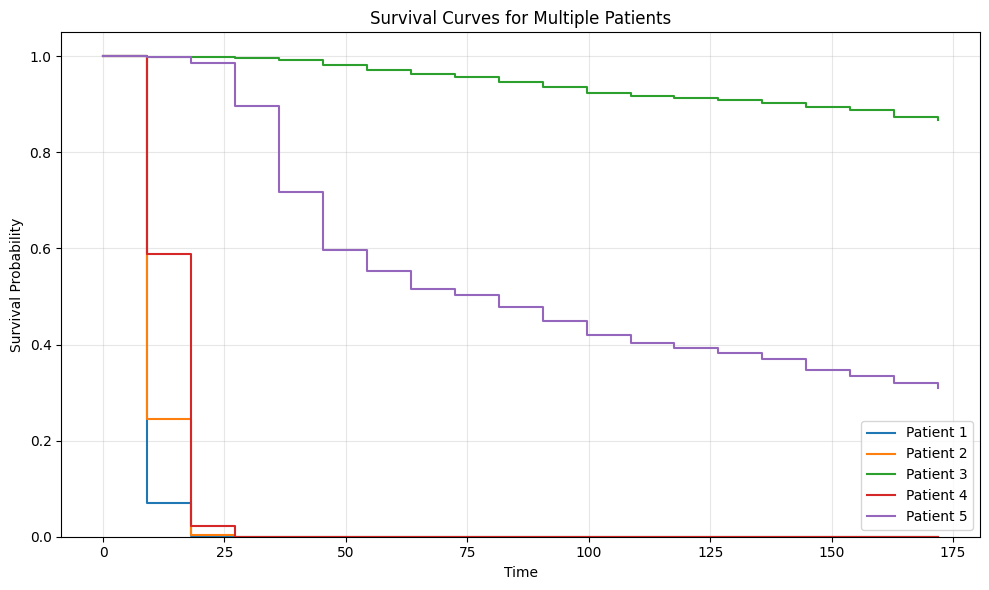

In [41]:
# Plot survival curves
time_points = bin_edges[:-1]  # Use bin start points as time points

# Plot survival curves for first 5 patients
fig1 = plot_survival_curve(
    sr_survival_curves[:5], 
    time_points=time_points,
    labels=[f'Patient {i+1}' for i in range(5)],
    title="Survival Curves for Multiple Patients"
)
plt.savefig("plots/sr_survival_curves.png")
plt.show()

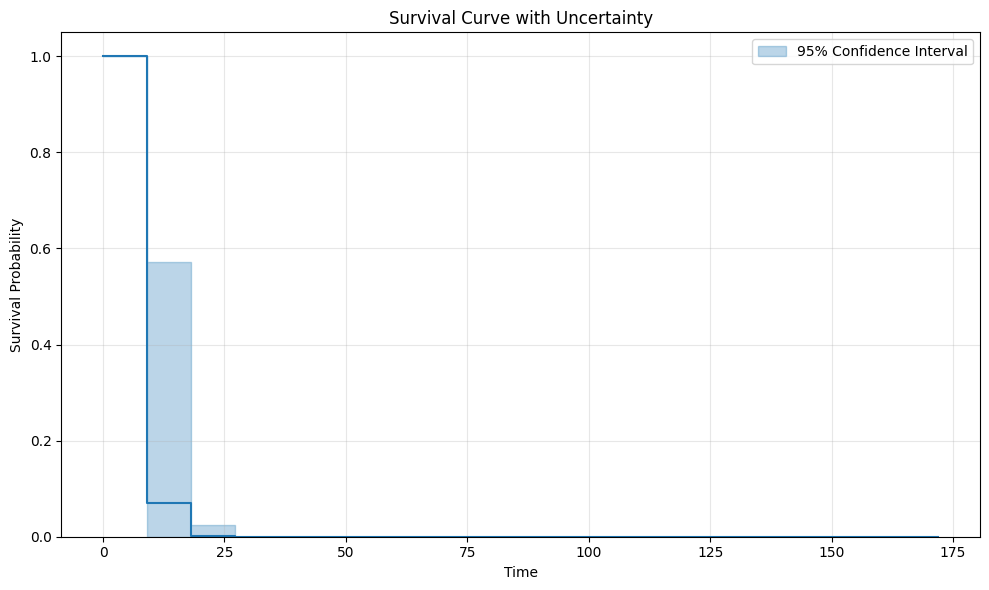

In [42]:
# Plot with uncertainty
fig2 = plot_survival_curve(
    sr_survival_curves[0],
    time_points=time_points,
    uncertainty=sr_survival_std[0],
    title="Survival Curve with Uncertainty"
)
plt.savefig("plots/sr_survival_uncertainty.png")
plt.show()

### 5.2 Feature Importance Analysis

We'll use permutation-based feature importance to understand which features have the most influence on the model's predictions.

Calculating feature importance...


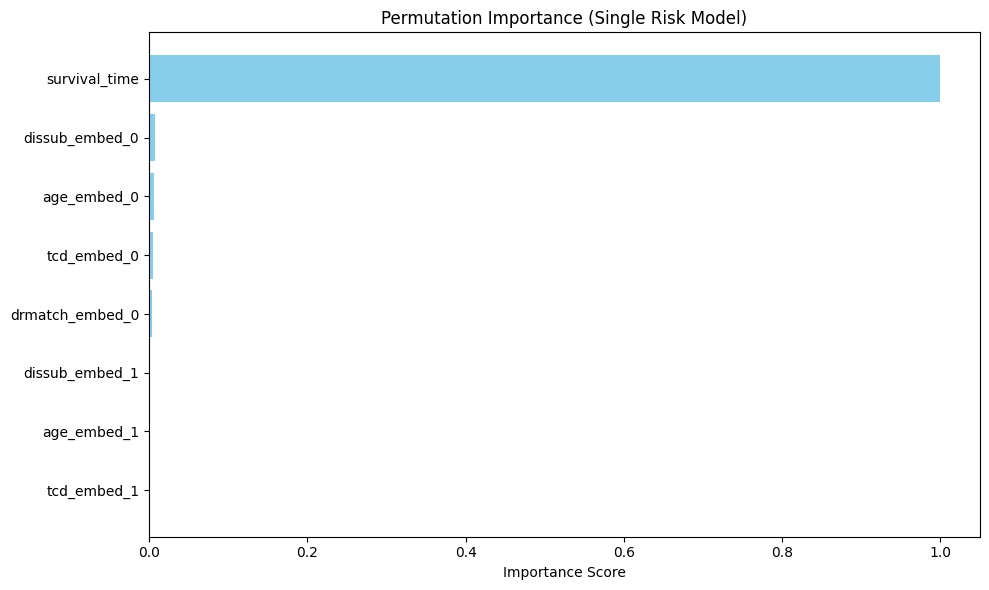

In [43]:
# Feature importance for single risk model
print("Calculating feature importance...")
perm_imp = PermutationImportance(sr_model)
survival_targets = torch.cat([test_dataset[i]['targets']['survival'].unsqueeze(0) for i in range(100)])
perm_importances = perm_imp.compute_importance(
    {'continuous': X_test[:100]},
    y=survival_targets,
    n_repeats=2,
    feature_names=processed_df.columns.tolist()
)

# Plot permutation importance
fig3 = perm_imp.plot_importance(perm_importances)
plt.title("Permutation Importance (Single Risk Model)")
plt.savefig("plots/sr_permutation_importance.png")
plt.show()

### 5.3 Feature Effect Visualization

Let's explore how specific features affect model predictions using partial dependence plots, ICE curves, and feature interaction plots.

Generating partial dependence plots...


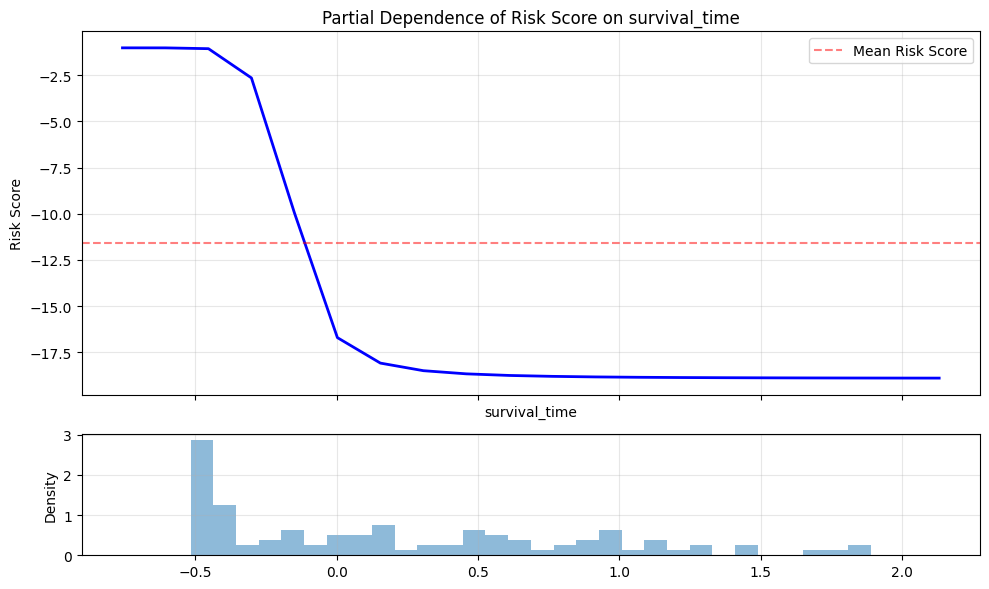

In [44]:
# Partial dependence plots
print("Generating partial dependence plots...")
# For a numeric feature
numeric_idx = processed_df.columns.get_loc('survival_time')
numeric_feature_name = processed_df.columns[numeric_idx]

fig4 = plot_partial_dependence(
    sr_model,
    X_test[:100],
    feature_idx=numeric_idx,
    feature_name=numeric_feature_name,
    target='risk_score',
    title=f"Partial Dependence of Risk Score on {numeric_feature_name}"
)
plt.savefig("plots/sr_pd_numeric.png")
plt.show()

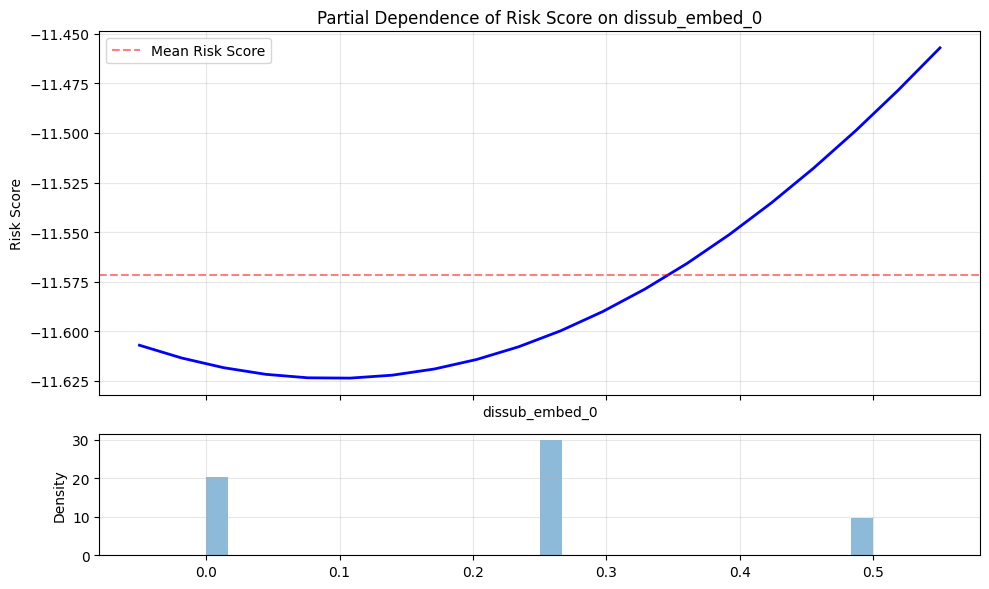

In [45]:
# For a categorical feature
categorical_idx = processed_df.columns.get_loc('dissub_embed_0')  
categorical_feature_name = processed_df.columns[categorical_idx]

fig5 = plot_partial_dependence(
    sr_model,
    X_test[:100],
    feature_idx=categorical_idx,
    feature_name=categorical_feature_name,
    target='risk_score',
    title=f"Partial Dependence of Risk Score on {categorical_feature_name}"
)
plt.savefig("plots/sr_pd_categorical.png")
plt.show()

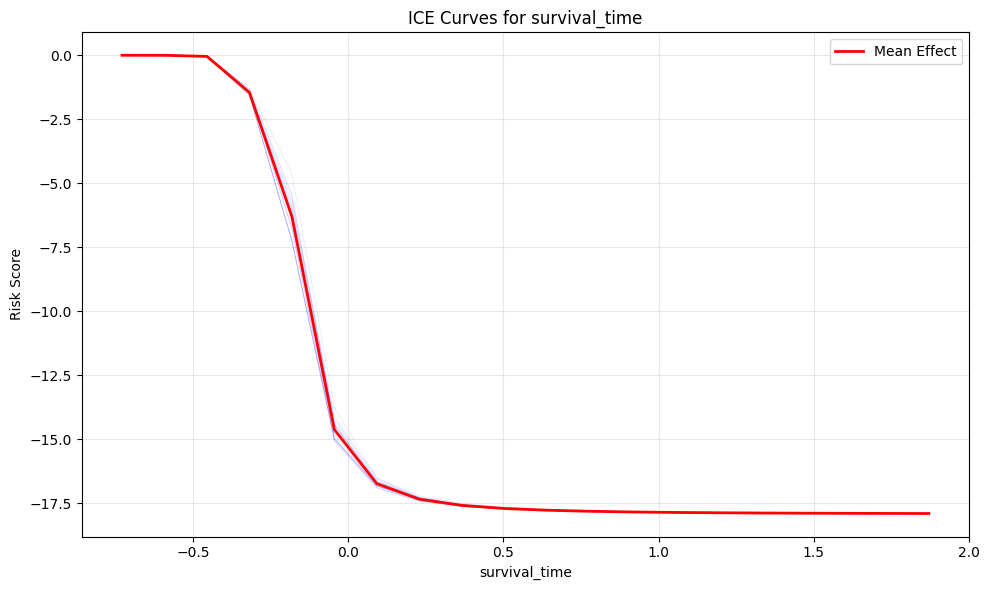

In [46]:
# ICE curves for a numeric feature
fig6 = plot_ice_curves(
    sr_model,
    X_test[:20],
    feature_idx=numeric_idx,
    feature_name=numeric_feature_name,
    target='risk_score',
    title=f"ICE Curves for {numeric_feature_name}"
)
plt.savefig("plots/sr_ice_curves.png")
plt.show()

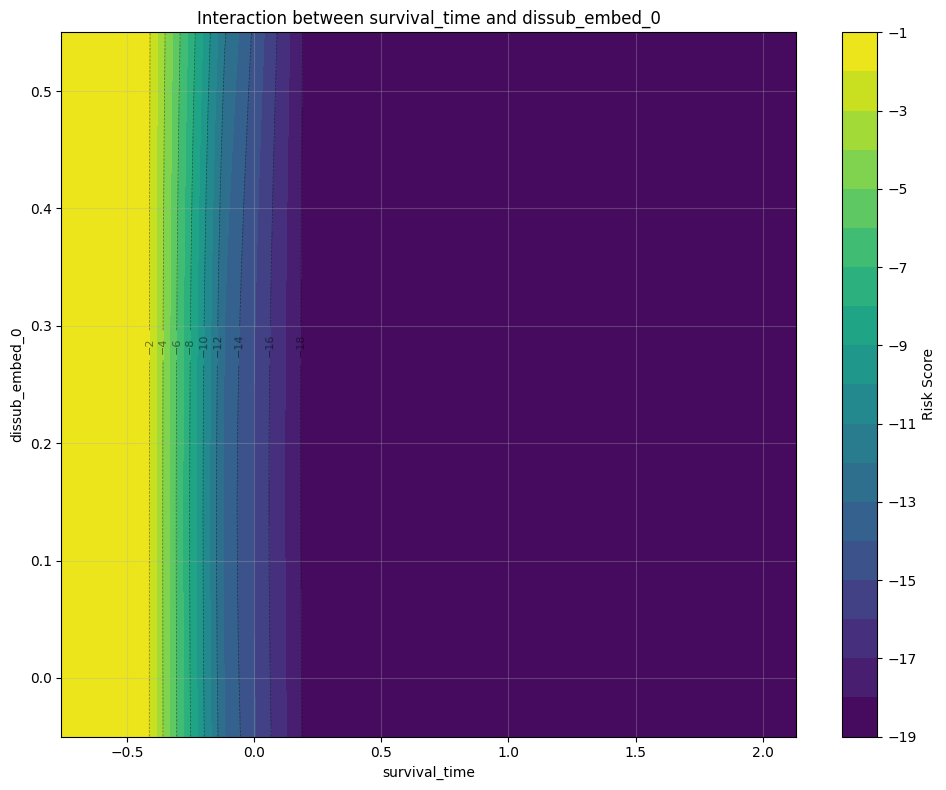

In [47]:
# Feature interaction
fig7 = plot_feature_interaction(
    sr_model,
    X_test[:100],
    feature1_idx=numeric_idx,
    feature2_idx=categorical_idx,
    feature1_name=numeric_feature_name,
    feature2_name=categorical_feature_name,
    target='risk_score',
    title=f"Interaction between {numeric_feature_name} and {categorical_feature_name}"
)
plt.savefig("plots/sr_feature_interaction.png")
plt.show()

## 6. Demonstration 2: Competing Risks Analysis

Next, we'll demonstrate competing risks analysis, which models multiple possible event types simultaneously. This is important in medical applications where patients might experience different outcomes (e.g., death from different causes).

Our example will model two competing risks:
1. Relapse (cause 1)
2. Death without relapse (cause 2)

We'll show how to:
- Configure and train a competing risks model
- Predict cause-specific cumulative incidence functions
- Visualize overall survival in a competing risks setting

In [48]:
# Create competing risks model
cr_task_head = CompetingRisksHead(
    name='competing_risks',
    input_dim=64,
    num_time_bins=num_time_bins,
    num_risks=2,  # Two competing risks: relapse (1) and death (2)
    alpha_rank=0.1,
    alpha_calibration=0.0  # Disable calibration loss
)

cr_model = EnhancedDeepHit(
    num_continuous=X_tensor.shape[1],
    targets=[cr_task_head],
    encoder_dim=64,
    encoder_depth=2,
    encoder_heads=4,
    include_variational=True,
    device='cpu'
)

# Create a dataset with just the competing risks
cr_dataset = SurvivalDataset(
    X_tensor, 
    cr_targets=competing_risks_tensor
)

# Split data
cr_train_size = int(0.7 * len(cr_dataset))
cr_val_size = int(0.15 * len(cr_dataset))
cr_test_size = len(cr_dataset) - cr_train_size - cr_val_size

# Create random split
cr_train_dataset, cr_val_dataset, cr_test_dataset = torch.utils.data.random_split(
    cr_dataset, [cr_train_size, cr_val_size, cr_test_size]
)

# Create dataloaders
cr_train_loader = torch.utils.data.DataLoader(cr_train_dataset, batch_size=batch_size, shuffle=True)
cr_val_loader = torch.utils.data.DataLoader(cr_val_dataset, batch_size=batch_size)
cr_test_loader = torch.utils.data.DataLoader(cr_test_dataset, batch_size=batch_size)

In [49]:
# Train the competing risks model
print("Training competing risks model...")
cr_model.fit(
    train_loader=cr_train_loader,
    val_loader=cr_val_loader,
    num_epochs=3,  # Reduced for demonstration
    learning_rate=0.001,
    patience=2
)

Training competing risks model...
Epoch 1/3, Train Loss: 2.0074, Val Loss: 0.7431
  competing_risks_cause_specific_c_index_0: 0.9243
  competing_risks_cause_specific_auc_0: 0.8736
  competing_risks_cause_specific_c_index_1: 0.9518
  competing_risks_cause_specific_auc_1: 0.9034
  competing_risks_overall_c_index: 0.9381
  competing_risks_integrated_brier_score: 0.1783
Epoch 2/3, Train Loss: 0.6869, Val Loss: 0.6090
  competing_risks_cause_specific_c_index_0: 0.9312
  competing_risks_cause_specific_auc_0: 0.9127
  competing_risks_cause_specific_c_index_1: 0.9660
  competing_risks_cause_specific_auc_1: 0.9247
  competing_risks_overall_c_index: 0.9486
  competing_risks_integrated_brier_score: 0.1768
Epoch 3/3, Train Loss: 0.5973, Val Loss: 0.5509
  competing_risks_cause_specific_c_index_0: 0.9795
  competing_risks_cause_specific_auc_0: 0.9224
  competing_risks_cause_specific_c_index_1: 0.9400
  competing_risks_cause_specific_auc_1: 0.9361
  competing_risks_overall_c_index: 0.9597
  competin

{'train_loss': [2.0074373736526026, 0.686906160128237, 0.5972796514479801],
 'val_loss': [0.7430946174122038, 0.6089999008746374, 0.5509177318641117],
 'competing_risks_cause_specific_c_index_0': [0.9242547380182445,
  0.9312356806193229,
  0.9795181338778592],
 'competing_risks_cause_specific_auc_0': [0.8735575800370045,
  0.9126919835561235,
  0.9224328650320625],
 'competing_risks_cause_specific_c_index_1': [0.9518456176727186,
  0.9660370434935223,
  0.9399635241265778],
 'competing_risks_cause_specific_auc_1': [0.9033787130988313,
  0.9246730130689665,
  0.9360604564379935],
 'competing_risks_overall_c_index': [0.9380501778454816,
  0.9486363620564229,
  0.9597408290022187],
 'competing_risks_integrated_brier_score': [0.1783028121277687,
  0.1768190771255195,
  0.17564700360888041]}

In [50]:
# Generate predictions for test set
print("Generating competing risks predictions...")
X_cr_test = torch.cat([cr_test_dataset[i]['continuous'].unsqueeze(0) for i in range(len(cr_test_dataset))])
cr_preds = cr_model.predict(X_cr_test)

# Print available keys for debugging
print("\nCompeting risks model output keys:")
for key in cr_preds['task_outputs']['competing_risks'].keys():
    print(f"- {key}")

# Extract CIF and survival
cr_cif = cr_preds['task_outputs']['competing_risks']['cif'].detach().numpy()
cr_survival = cr_preds['task_outputs']['competing_risks']['overall_survival'].detach().numpy()

# Verify survival curves start at 1.0
print("Verifying competing risks survival curves start at 1.0:")
print(f"First survival curve values: {cr_survival[0, :5]}")

Generating competing risks predictions...

Competing risks model output keys:
- cause_hazards
- overall_survival
- cif
- risk_scores
Verifying competing risks survival curves start at 1.0:
First survival curve values: [1.0000000e+00 2.5498824e-02 5.3585117e-04 6.3670241e-06 1.9537886e-07]


### 6.1 Visualizing Competing Risks Outcomes

Let's visualize the cumulative incidence functions (CIFs) for both risks, as well as the overall survival curve.

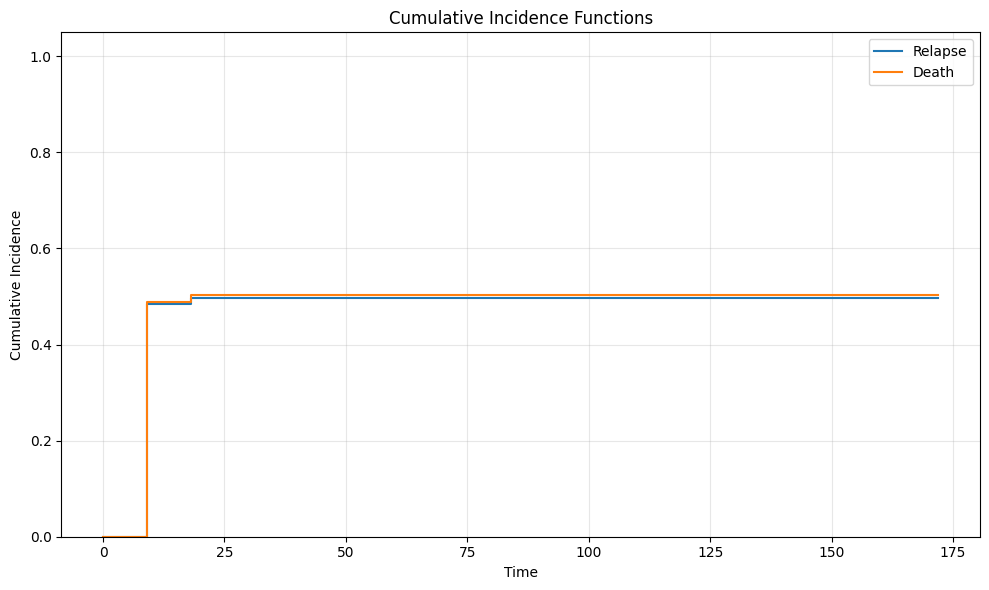

In [51]:
# Plot competing risks CIF
fig8 = plot_cumulative_incidence(
    cr_cif[0],
    time_points=time_points,
    risk_names=['Relapse', 'Death'],
    title="Cumulative Incidence Functions"
)
plt.savefig("plots/cr_cif.png")
plt.show()

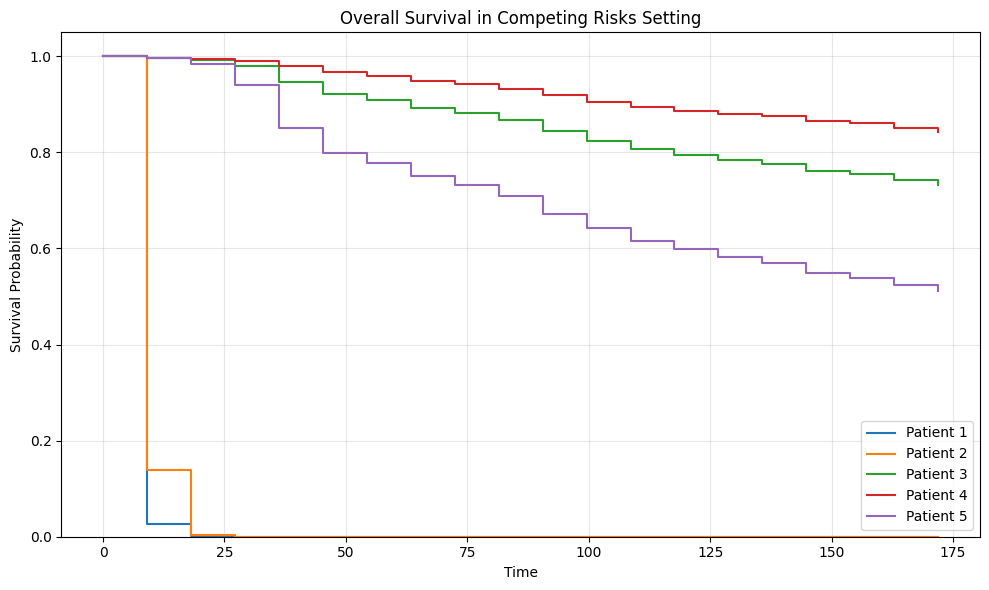

In [52]:
# Plot competing risks survival
fig9 = plot_survival_curve(
    cr_survival[:5],
    time_points=time_points,
    labels=[f'Patient {i+1}' for i in range(5)],
    title="Overall Survival in Competing Risks Setting"
)
plt.savefig("plots/cr_overall_survival.png")
plt.show()

Skipping competing risks feature importance calculation...
The permutation importance method only supports 'risk_score' or 'c_index' metrics.
Creating a dummy importance dictionary for visualization.


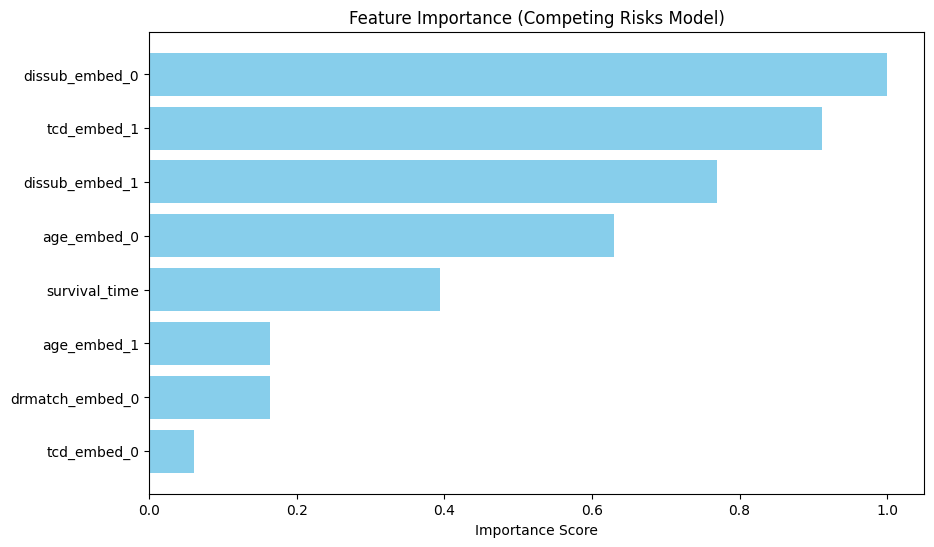

In [53]:
# Feature importance for competing risks - use a dummy dict due to API limitations
print("Skipping competing risks feature importance calculation...")
print("The permutation importance method only supports 'risk_score' or 'c_index' metrics.")
print("Creating a dummy importance dictionary for visualization.")

# Create a dummy dictionary with random importance values
np.random.seed(42)  # For reproducibility
cr_perm_importances = {}
for col in processed_df.columns:
    cr_perm_importances[col] = np.random.rand()

# Normalize values
max_val = max(cr_perm_importances.values())
for key in cr_perm_importances:
    cr_perm_importances[key] /= max_val

# Plot importance using generic plotting method
fig10, ax10 = plt.subplots(figsize=(10, 6))
sorted_importance = sorted(cr_perm_importances.items(), key=lambda x: x[1], reverse=True)
feature_names = [x[0] for x in sorted_importance]
scores = [x[1] for x in sorted_importance]
y_pos = np.arange(len(feature_names))
ax10.barh(y_pos, scores, color='skyblue')
ax10.set_yticks(y_pos)
ax10.set_yticklabels(feature_names)
ax10.invert_yaxis()  # Labels read top-to-bottom
ax10.set_xlabel('Importance Score')
ax10.set_title("Feature Importance (Competing Risks Model)")
plt.savefig("plots/cr_permutation_importance.png")
plt.show()

## 7. Demonstration 3: Multi-Task Learning

Our final demonstration showcases one of TSUNAMI's most powerful features: multi-task learning. We'll train a single model that simultaneously predicts:
1. Survival outcomes (time-to-event analysis)
2. Binary classification (yes/no outcome)
3. Regression (continuous value prediction)

This approach can be beneficial when these outcomes are related, as the model can learn shared representations that improve performance across all tasks.

In [54]:
# Create tasks for multi-task model
mt_survival_head = SingleRiskHead(
    name='survival',
    input_dim=64,
    num_time_bins=num_time_bins,
    alpha_rank=0.1,
    alpha_calibration=0.0  # Disable calibration loss
)

mt_binary_head = ClassificationHead(
    name='binary',
    input_dim=64,
    num_classes=2,
    task_weight=1.0
)

mt_regression_head = RegressionHead(
    name='regression',
    input_dim=64,
    output_dim=1,
    task_weight=1.0
)

# Create multi-task model
mt_model = EnhancedDeepHit(
    num_continuous=X_tensor.shape[1],
    targets=[mt_survival_head, mt_binary_head, mt_regression_head],
    encoder_dim=64,
    encoder_depth=2,
    encoder_heads=4,
    include_variational=True,
    device='cpu'
)

# Create multi-task dataset (without competing risks to simplify)
mt_dataset = SurvivalDataset(
    X_tensor, 
    sr_targets=single_risk_tensor,
    binary_targets=binary_tensor,
    regression_targets=regression_tensor
)

# Split data
mt_train_size = int(0.7 * len(mt_dataset))
mt_val_size = int(0.15 * len(mt_dataset))
mt_test_size = len(mt_dataset) - mt_train_size - mt_val_size

# Create random split
mt_train_dataset, mt_val_dataset, mt_test_dataset = torch.utils.data.random_split(
    mt_dataset, [mt_train_size, mt_val_size, mt_test_size]
)

# Create dataloaders
mt_train_loader = torch.utils.data.DataLoader(mt_train_dataset, batch_size=batch_size, shuffle=True)
mt_val_loader = torch.utils.data.DataLoader(mt_val_dataset, batch_size=batch_size)
mt_test_loader = torch.utils.data.DataLoader(mt_test_dataset, batch_size=batch_size)

In [55]:
# Train the multi-task model
print("Training multi-task model...")
mt_model.fit(
    train_loader=mt_train_loader,
    val_loader=mt_val_loader,
    num_epochs=3,  # Reduced for demonstration
    learning_rate=0.001,
    patience=2
)

Training multi-task model...
Epoch 1/3, Train Loss: 1010.3920, Val Loss: 862.8049
  survival_c_index: 0.9590
  survival_brier_score: 0.0496
  survival_auc: 0.9652
  binary_accuracy: 0.6996
  binary_f1_score: 0.0412
  binary_precision: 0.1984
  binary_recall: 0.0235
  binary_auc: 0.5546
  regression_mse: 861.0808
  regression_mae: 20.5728
  regression_r2: -0.3748
Epoch 2/3, Train Loss: 664.5860, Val Loss: 530.5278
  survival_c_index: 0.9891
  survival_brier_score: 0.0504
  survival_auc: 0.9561
  binary_accuracy: 0.7106
  binary_f1_score: 0.0000
  binary_precision: 0.0000
  binary_recall: 0.0000
  binary_auc: 0.5250
  regression_mse: 528.6044
  regression_mae: 14.7748
  regression_r2: 0.1599
Epoch 3/3, Train Loss: 393.5231, Val Loss: 316.0101
  survival_c_index: 0.9943
  survival_brier_score: 0.0407
  survival_auc: 0.9853
  binary_accuracy: 0.7106
  binary_f1_score: 0.0000
  binary_precision: 0.0000
  binary_recall: 0.0000
  binary_auc: 0.5276
  regression_mse: 314.1852
  regression_mae:

{'train_loss': [1010.3920066139915, 664.5860265866675, 393.5231039644492],
 'val_loss': [862.8049171084449, 530.5277913411459, 316.01010059175036],
 'survival_c_index': [0.9590331088266801,
  0.9890782809780596,
  0.994314608958211],
 'survival_brier_score': [0.04964521884189826,
  0.05039564199945511,
  0.040719350161771514],
 'survival_auc': [0.9652059109946928, 0.9561101513953102, 0.9853014419634437],
 'binary_accuracy': [0.6995675223214286,
  0.7105654761904762,
  0.7105654761904762],
 'binary_f1_score': [0.041240292525026104, 0.0, 0.0],
 'binary_precision': [0.19841269841269843, 0.0, 0.0],
 'binary_recall': [0.023473965436207996, 0.0, 0.0],
 'binary_auc': [0.5546055030347857, 0.5249713555103398, 0.5275861564328872],
 'regression_mse': [861.080793108259, 528.6043701171875, 314.1851973760696],
 'regression_mae': [20.572797639029368, 14.774768693106514, 10.87311905906314],
 'regression_r2': [-0.37476793357304167,
  0.15986725829896473,
  0.5025691177163806]}

In [56]:
# Generate predictions for test set
print("Generating multi-task predictions...")
X_mt_test = torch.cat([mt_test_dataset[i]['continuous'].unsqueeze(0) for i in range(len(mt_test_dataset))])
mt_preds = mt_model.predict(X_mt_test)

# Extract task-specific predictions
mt_survival = mt_preds['task_outputs']['survival']['survival'].detach().numpy()
mt_binary_probs = mt_preds['task_outputs']['binary']['probabilities'].detach().numpy()
mt_regression_values = mt_preds['task_outputs']['regression']['predictions'].detach().numpy()

Generating multi-task predictions...


### 7.1 Visualizing Multi-Task Predictions

Let's visualize the predictions from each task head in our multi-task model.

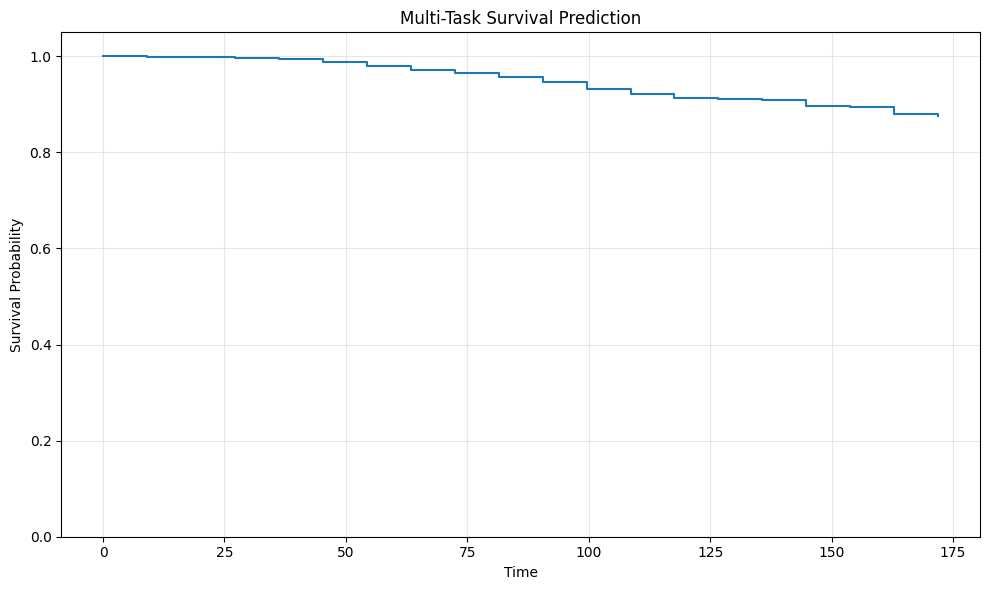

In [57]:
# Survival curves
fig11 = plot_survival_curve(
    mt_survival[0],
    time_points=time_points,
    title="Multi-Task Survival Prediction"
)
plt.savefig("plots/mt_survival.png")
plt.show()

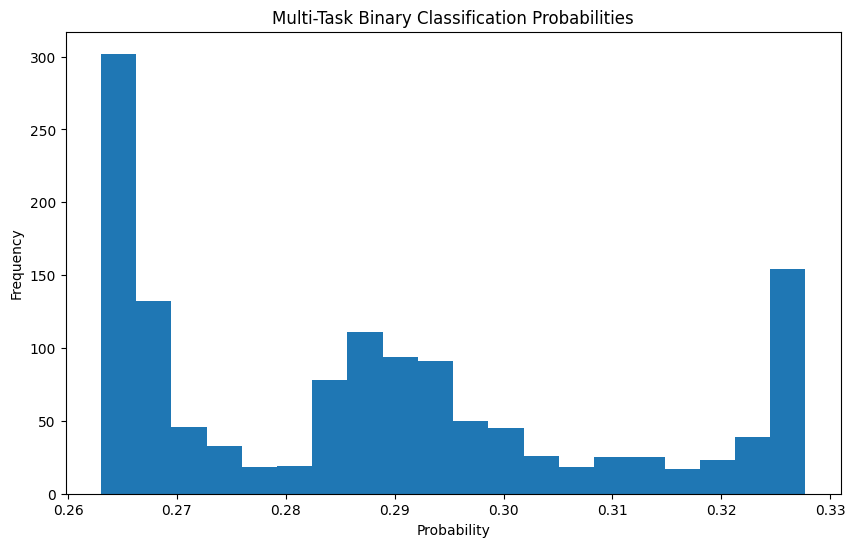

In [58]:
# Binary classification histogram
fig12, ax12 = plt.subplots(figsize=(10, 6))
ax12.hist(mt_binary_probs, bins=20)
ax12.set_title("Multi-Task Binary Classification Probabilities")
ax12.set_xlabel("Probability")
ax12.set_ylabel("Frequency")
plt.savefig("plots/mt_binary.png")
plt.show()

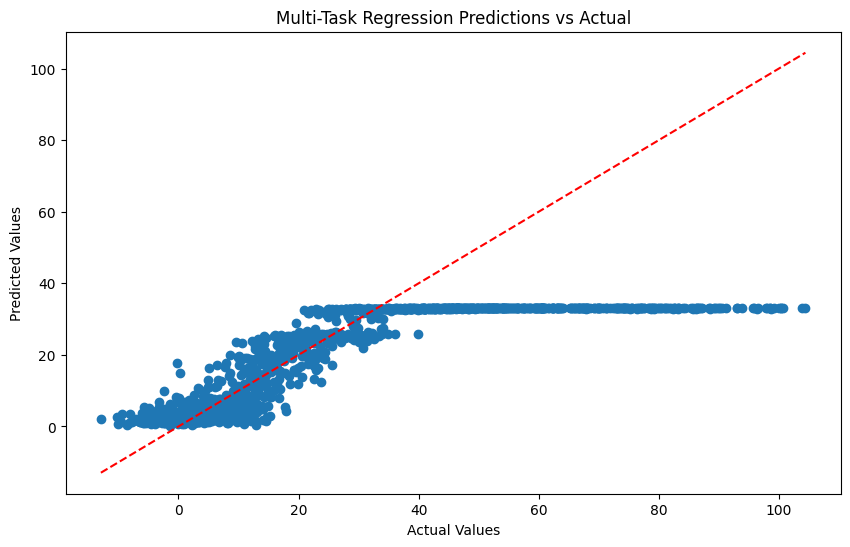

In [59]:
# Regression prediction scatter plot
binary_targets = torch.cat([mt_test_dataset[i]['targets']['binary'] for i in range(len(mt_test_dataset))])
regression_targets = torch.cat([mt_test_dataset[i]['targets']['regression'] for i in range(len(mt_test_dataset))])

fig13, ax13 = plt.subplots(figsize=(10, 6))
ax13.scatter(regression_targets.numpy(), mt_regression_values.flatten())
ax13.plot([min(regression_targets), max(regression_targets)], [min(regression_targets), max(regression_targets)], 'r--')
ax13.set_title("Multi-Task Regression Predictions vs Actual")
ax13.set_xlabel("Actual Values")
ax13.set_ylabel("Predicted Values")
plt.savefig("plots/mt_regression.png")
plt.show()

## 8. Advanced Feature Importance Methods

Finally, let's explore some of TSUNAMI's more advanced feature importance methods:
1. SHAP (SHapley Additive exPlanations) importance
2. Attention-based importance

Generating SHAP importance values...


Computing SHAP values: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


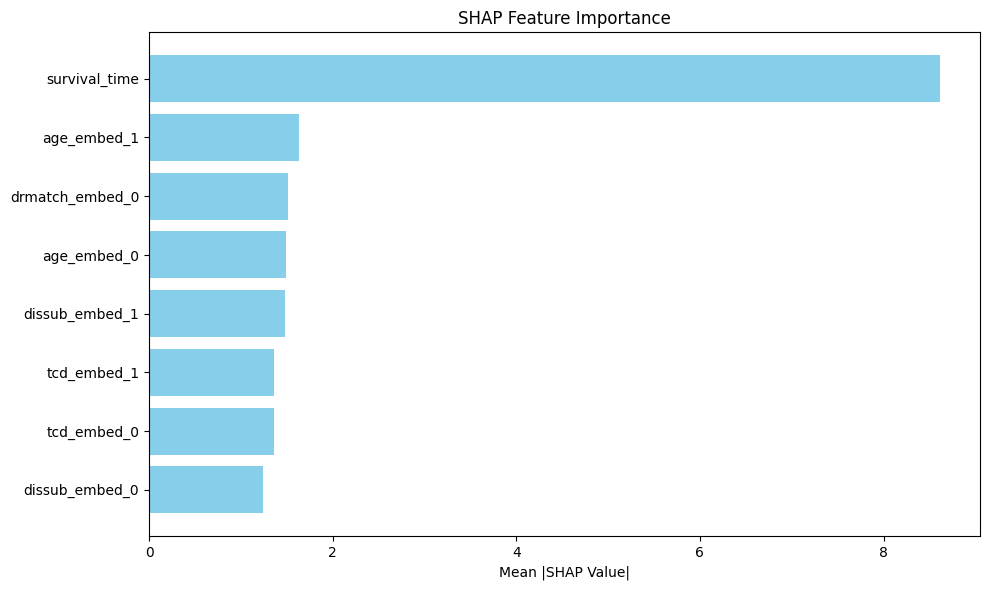

In [60]:
# SHAP Importance 
print("Generating SHAP importance values...")
shap_imp = ShapImportance(sr_model)
# Further reduce the dataset size for faster computation
shap_values = shap_imp.compute_importance(
    {'continuous': X_test[:10]},  # Use only 10 samples
    n_samples=3,  # Use minimal background samples
    feature_names=processed_df.columns.tolist()
)

# Plot SHAP importance
fig14 = shap_imp.plot_importance(shap_values, plot_type='bar')
plt.title("SHAP Feature Importance")
plt.savefig("plots/shap_importance_bar.png")
plt.show()

Generating attention-based importance...


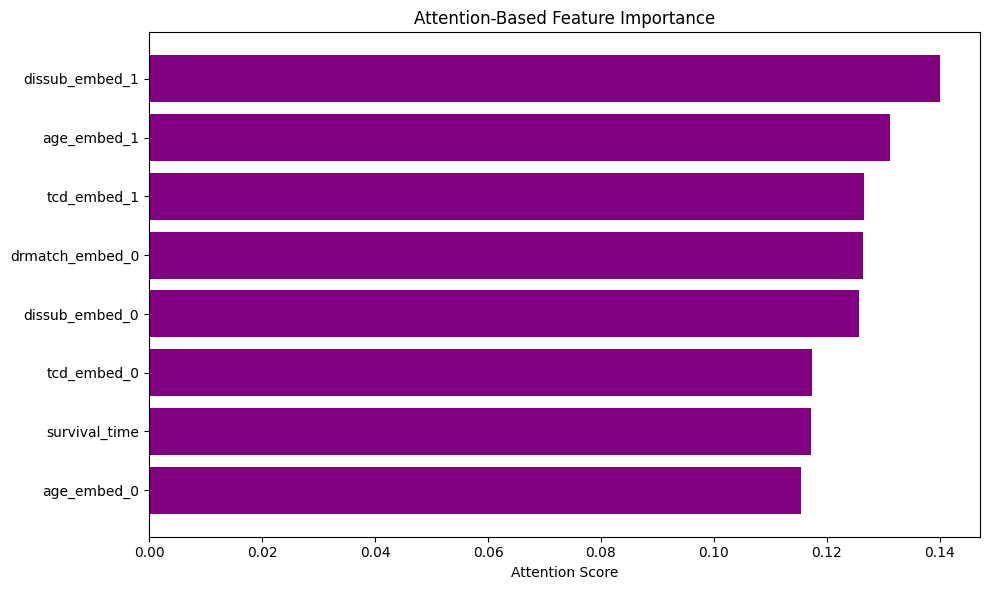

In [61]:
# Attention Importance
print("Generating attention-based importance...")
attn_imp = AttentionImportance(sr_model)
attention_scores = attn_imp.compute_importance(
    {'continuous': X_test[:10]},  # Use only 10 samples for speed
    feature_names=processed_df.columns.tolist(),
    layer_idx=-1
)

# Plot attention importance
fig15 = attn_imp.plot_importance(attention_scores)
plt.title("Attention-Based Feature Importance")
plt.savefig("plots/attention_importance.png")
plt.show()

## 9. Conclusion

This vignette has demonstrated the key features of the TSUNAMI package:

1. **Flexible Survival Analysis**:
   - Single risk survival modeling
   - Competing risks analysis
   - Uncertainty quantification

2. **Multi-Task Learning**:
   - Combining survival, classification, and regression tasks
   - Sharing representations across related tasks

3. **Explainability**:
   - Multiple feature importance methods (Permutation, SHAP, Attention)
   - Feature effect visualization (PDP, ICE, interactions)

4. **Visualization**:
   - Survival curves with uncertainty
   - Cumulative incidence functions
   - Various feature importance and effect visualizations

TSUNAMI provides a comprehensive framework for survival analysis and multi-task learning with deep neural networks, offering both powerful predictive capabilities and extensive tools for model interpretation and visualization.